# Density Profiles at Given Times

This notebook plots a number of density profiles at given times and plots an underlying signal. Both in $\rho$ and in R.

In [1]:
%matplotlib notebook

import matplotlib
# matplotlib.use("Agg")
from IPython.core.display import display, HTML
from ipfnpytools.getsig import getsig
import ipfnpytools.aug_read as aug_read
from ipfnpytools.closest import closest
from __future__ import print_function
from ipfnpytools.plot import plots
from warnings import warn
import numpy as np
from ipfnpytools.save_figure import save_figure
from ipfnpytools import rps_dump
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets

## Parameters

Change these parameters to fit your needs

In [2]:
# Shot number
shot = 37765

# Choose edition for reflectometry (0 for most recent)
edition = 0

# Choose profile source between 'afs' and 'dump'
source = 'afs'

# Path to dump file 
path = None 

# If chosen 'dump', state the relative path
support_signal = ('FPG', 'delRoben')

# Choose edition for the supporting signal (0 for most recent)
support_signal_edition = 0

# Magnetic equillibrium
equillibrium = "EQH"

# Number of density profiles to show in the plots
number_of_profiles = 3

## Load support signal from AFS

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(err_txt, RuntimeWarning)


<IPython.core.display.Javascript object>


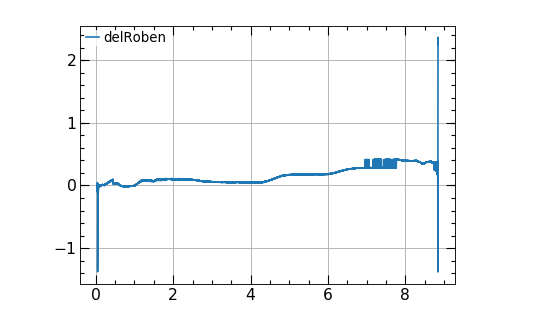

(<Figure size 535.433x330.916 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b9f65e71c10>)

In [3]:
signal = getsig(shot, support_signal[0], support_signal[1], edition=support_signal_edition)
plots(signal.time, signal.data, labels=signal.name)

## Get density profile data

In [4]:
if source == 'dump':
    # Instantiate the ShotFile class with the path to the dump file
    shotfile = rps_dump.ShotFile(path)

    ne_lfs = shotfile("neb_LFS")
    ne_hfs = shotfile("neb_HFS")

    # Time array is equal for LFS and HFS
    time = ne_lfs.time

    # Low-field side
    lfs_signal = ne_lfs.data
    lfs_area = ne_lfs.area.data

    # High-field side
    hfs_signal = ne_hfs.data
    hfs_area = ne_hfs.area.data
    
elif source == 'afs':

    data = aug_read.many_signals(
        diagnostics=(["RPS"] * 2),
        names=['neb_LFS', 'neb_HFS'],
        shots=shot,
        editions=edition
    )

    # Time array is equal for LFS and HFS
    time = data.times[0]

    # Low-field side
    lfs_signal = data.signals[0]
    lfs_area = data.areas[0]

    # High-field side
    hfs_signal = data.signals[1]
    hfs_area = data.areas[1]


print("time:", time.shape)
print("lfs_signal:", lfs_signal.shape)
print("lfs_area:", lfs_area.shape)
print("hfs_signal:", hfs_signal.shape)
print("hfs_area:", hfs_area.shape)

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgrp (8.1): No PARAM_SET found
  warnings.warn(err_txt, RuntimeWarning)


time: (17051,)
lfs_signal: (17051, 151)
lfs_area: (17051, 151)
hfs_signal: (17051, 151)
hfs_area: (17051, 151)


<IPython.core.display.Javascript object>


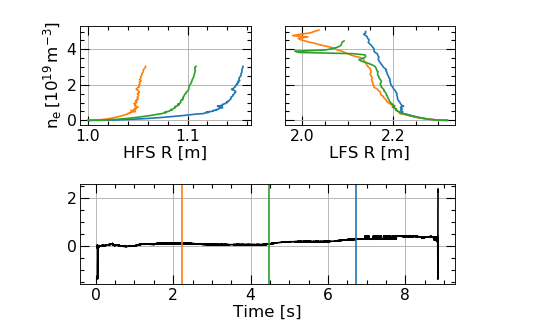

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTYuNzEzOTU3Nzg2NTYwMDU5LCBkZXNjcmlwdGlvbj11J3NsaWRlciAyJywgbWF4PTguOTUxNTA3NTY4MzU5Mzc1LCBtaW7igKY=


In [5]:
draw = np.linspace(0, len(time), number_of_profiles + 2, dtype=np.int)
draw = draw[1:-1]

rin = getsig(shot, 'GQH', 'Rin')
raus = getsig(shot, 'GQH', 'Raus')

fig1 = plt.figure()
plt.subplots_adjust(wspace=0.2, hspace=0.6)

# Supporting plot with colored lines
ax1 = plt.subplot(212)
stamp = []
ax1.plot(signal.time, signal.data, color='k')
for i in draw:
    l = ax1.axvline(time[i], color=next(ax1._get_lines.prop_cycler)['color'])
    stamp.append(l)


ax2 = plt.subplot(221)

ax3 = plt.subplot(222, sharey=ax2)
ax3.tick_params(labelleft=False)

hfs = []
for i in draw:
    l, = ax2.plot(hfs_area[i], hfs_signal[i]*1e-19)
    hfs.append(l)

lfs = []
for i in draw:
    l, = ax3.plot(lfs_area[i], lfs_signal[i]*1e-19)
    lfs.append(l)


#labels & text
ax2.set_ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
ax2.set_xlabel('HFS R [m]')
ax3.set_xlabel('LFS R [m]')
ax1.set_xlabel('Time [s]')


testing_slider = widgets.FloatSlider(
        value=time[draw[0]],
        min=time[0],
        max=time[-1],
        step=time[1]-time[0],
        description='Time:',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.6f',
    )


def update1(**kwargs):
    for i, ts in enumerate(kwargs.values()):
        time_index = closest(time, ts)
        hfs[i].set_xdata(hfs_area[time_index])
        lfs[i].set_xdata(lfs_area[time_index])
        stamp[i].set_xdata(2*[ts])
    fig1.canvas.draw_idle()
    
    
sliders = []
for i in range(number_of_profiles):
    sliders.append(widgets.FloatSlider(
        value=time[draw[i]],
        min=time[0],
        max=time[-1],
        step=time[1]-time[0],
        description='slider %d'%i,
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.6f',
    ))
    
kwargs = {'p{0}'.format(i):slider for i, slider in enumerate(sliders)}

widgets.interact(update1, **kwargs);
    

# #Inner vessel wall
# ax1[0].axvspan(1.0, 1.045, color='#D3D3D3')
# #ICRH limiter
# ax1[1].axvspan(2.22, 2.23, color='#D3D3D3')

# #Readjust X axis
# ax1[0].set_xlim(1.0, 1.35)
# ax1[1].set_xlim(1.98, 2.23)

# #Separatrices
# rinr = rin.data[closest(rin.time, time[0])]
# ax1[0].axvspan(rinr, 1.35, color='#FFC0CB')

# rausr = raus.data[closest(raus.time, time[0])]
# ax1[1].axvspan(1.98, rausr, color='#FFC0CB')


In [12]:
save_figure(fig1, "timed_profiles")

Figure saved to /afs/ipp-garching.mpg.de/home/d/danielhfc/lab_rot/phd_part2_isodensity_and_timestamp/timed_profiles.png


## Change coordinates to $\rho$

In [6]:
import dd #To read 
import kk_abock
import numpy as np
from ipfnpytools.trz_to_rhop import trz_to_rhop

In [7]:
# Set the antenna Z
zl = 0.14
zh = 0.07

# Walls
inner_wall = 1.045
outer_wall = 2.22

inner_wall_rho = trz_to_rhop(3, inner_wall, zh, shot, eq=equillibrium)
outer_wall_rho = trz_to_rhop(3, outer_wall, zl, shot, eq=equillibrium)
rhol = trz_to_rhop(time, lfs_area, np.ones_like(lfs_area)*zl, shot, eq=equillibrium)
rhoh = trz_to_rhop(time, hfs_area, np.ones_like(hfs_area)*zh, shot, eq=equillibrium)

trz_to_rhop:1/1
trz_to_rhop:1/1
trz_to_rhop:17051/17051
trz_to_rhop:17051/17051


<IPython.core.display.Javascript object>


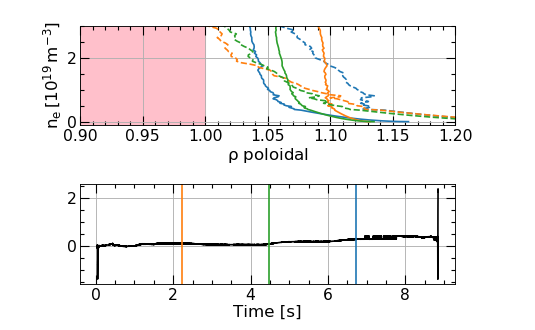

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTYuNzEzOTU3Nzg2NTYwMDU5LCBkZXNjcmlwdGlvbj11J3NsaWRlciAyJywgbWF4PTguOTUxNTA3NTY4MzU5Mzc1LCBtaW7igKY=


In [8]:
fig2 = plt.figure()
plt.subplots_adjust(hspace=0.6)

# Supporting plot with colored lines
ax4 = plt.subplot(212)
stamp = []
ax4.plot(signal.time, signal.data, color='k')
for i in draw:
    l = ax4.axvline(time[i], color=next(ax4._get_lines.prop_cycler)['color'])
    stamp.append(l)


ax5 = plt.subplot(211)

hfs = []
lfs = []
for i in draw:
    l, = ax5.plot(rhoh[i], hfs_signal[i]*1e-19)
    hfs.append(l)
    l, = ax5.plot(rhol[i], lfs_signal[i]*1e-19, color=l.get_color(), linestyle='--')
    lfs.append(l)
    

#labels & text
ax5.set_ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
ax5.set_xlabel(r'$\rho$ poloidal')
ax4.set_xlabel('Time [s]')

ax5.axvspan(0.0, 1.0, color='#FFC0CB')

ax5.set_xlim(0.9, 1.2)
ax5.set_ylim(-0.1, 3)


def update2(**kwargs):
    for i, ts in enumerate(kwargs.values()):
        time_index = closest(time, ts)
        hfs[i].set_xdata(rhoh[time_index])
        lfs[i].set_xdata(rhol[time_index])
        stamp[i].set_xdata(2*[ts])
    fig2.canvas.draw_idle()
    
    
sliders2 = []
for i in range(number_of_profiles):
    sliders2.append(widgets.FloatSlider(
        value=time[draw[i]],
        min=time[0],
        max=time[-1],
        step=time[1]-time[0],
        description='slider %d'%i,
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.6f',
    ))
    
kwargs = {'p{0}'.format(i):slider for i, slider in enumerate(sliders2)}

widgets.interact(update2, **kwargs);

In [10]:
save_figure(fig2, "three_plots_rho")

Figure saved to /afs/ipp-garching.mpg.de/home/d/danielhfc/lab_rot/phd_part2_isodensity_and_timestamp/three_plots_rho.png
